# Hough transform
The purpose of this repository is to demonstrate the Hough transform to detect circles in images

## Hough Circles
implementation of the Hough circles transform.


In [15]:
from typing import List
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def nms(xyr: np.ndarray, radius: int) -> list:
    """
    Performes Non Maximum Suppression in order to remove circles that are close
    to each other to get a "clean" output.
    :param xyr:
    :param radius:
    :return:
    """
    ret_xyr = []

    while len(xyr) > 0:
        # Choose most ranked circle (MRC)
        curr_arg = xyr[:, -1].argmax()
        curr = xyr[curr_arg, :]
        ret_xyr.append(curr)
        xyr = np.delete(xyr, curr_arg, axis=0)

        # Find MRC close neighbors
        dists = np.sqrt(np.square(xyr[:, :2] - curr[:2]).sum(axis=1)) < radius
        idx_to_delete = np.where(dists)

        # Delete MRCs neighbors
        xyr = np.delete(xyr, idx_to_delete, axis=0)
    return ret_xyr

def houghCircle(img: np.ndarray, min_radius: int, max_radius: int) -> list:
    """
    Find Circles in an image using a Hough Transform algorithm extension
    :param img: Input image
    :param min_radius: Minimum circle radius
    :param max_radius: Maximum circle radius
    :return: A list containing the detected circles,
                [(x,y,radius),(x,y,radius),...]
    """
    img = img.squeeze()
    if img.ndim > 2:
        raise ValueError("The image is not grayscale")

    h, w = img.shape
    max_radius = min(min(h, w) // 2, max_radius)

    # Get each pixels gradients direction
    i_y = cv2.Sobel(img, -1, 0, 1, ksize=3)
    i_x = cv2.Sobel(img, -1, 1, 0, ksize=3)
    ori = np.arctan2(i_y, i_x)

    # Get Edges using Canny Edge detector
    bw = cv2.Canny((img * 255).astype(np.uint8), 550, 100)

    radius_diff = max_radius - min_radius
    circle_hist = np.zeros((h, w, radius_diff))

    # Get the coordinates only for the edges
    ys, xs = np.where(bw)

    # Calculate the sin/cos for each edge pixel
    sins = np.sin(ori[ys, xs])
    coss = np.cos(ori[ys, xs])

    r_range = np.arange(min_radius, max_radius)
    for iy, ix, ss, cs in zip(ys, xs, sins, coss):
        grad_sin = (r_range * ss).astype(int)
        grad_cos = (r_range * cs).astype(int)

        xc_1 = ix + grad_cos
        yc_1 = iy + grad_sin

        xc_2 = ix - grad_cos
        yc_2 = iy - grad_sin

        # Check where are the centers that are in the image
        r_idx1 = np.logical_and(yc_1 > 0, xc_1 > 0)
        r_idx1 = np.logical_and(r_idx1, np.logical_and(yc_1 < h, xc_1 < w))

        # Check where are the centers that are in the image (Opposite direction)
        r_idx2 = np.logical_and(yc_2 > 0, xc_2 > 0)
        r_idx2 = np.logical_and(r_idx2, np.logical_and(yc_2 < h, xc_2 < w))

        # Add circles to the circle histogram
        circle_hist[yc_1[r_idx1], xc_1[r_idx1], r_idx1] += 1
        circle_hist[yc_2[r_idx2], xc_2[r_idx2], r_idx2] += 1

    # Find all the circles centers
    y, x, r = np.where(circle_hist > 11)
    circles = np.array([x, y, r + min_radius, circle_hist[y, x, r]]).T

    # Perform NMS
    circles = nms(circles, min_radius // 2)
    return circles

In [26]:
def houghDemo(path, min_r, max_r):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) / 255

    hough_rings = houghCircle(img, min_r, max_r)

    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    

    for c in hough_rings:
        circle1 = plt.Circle((c[0], c[1]), c[2], color='r', fill=False, linewidth=3)
        ax.add_artist(circle1)
    plt.show()

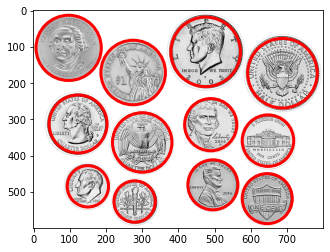

In [27]:
houghDemo('coins.jpg',50,100)

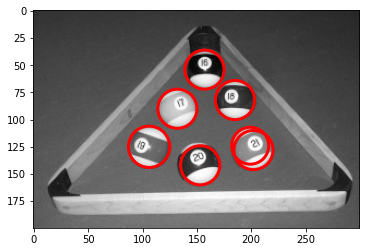

In [28]:
houghDemo('pool_balls.jpeg',10,20)